In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import warnings
warnings.filterwarnings('ignore')


### Dataset Load

In [2]:
headers = ["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style",
           "drive-wheels", "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type",
           "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower",
           "peak-rpm", "city-mpg", "highway-mpg", "price"]

In [3]:
df = pd.read_csv('./imports-85.data', sep=',', encoding='utf-8', header=None, names=headers)

### Data Understanding

In [5]:
df.describe(include='all')

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205,205,205,205,205,205,205,205,205.000000,205.000000,205.000000,205.000000,205.000000,205,205,205.000000,205,205,205,205.000000,205,205,205.000000,205.00000,205
unique,NaN,52,22,2,2,3,5,3,2,NaN,NaN,NaN,NaN,NaN,7,7,NaN,8,39,37,NaN,60,24,NaN,NaN,187
top,NaN,?,toyota,gas,std,four,sedan,fwd,front,NaN,NaN,NaN,NaN,NaN,ohc,four,NaN,mpfi,3.62,3.40,NaN,68,5500,NaN,NaN,?
freq,NaN,41,32,185,168,114,96,120,202,NaN,NaN,NaN,NaN,NaN,148,159,NaN,94,23,20,NaN,19,37,NaN,NaN,4
mean,0.834146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.756585,174.049268,65.907805,53.724878,2555.565854,NaN,NaN,126.907317,NaN,NaN,NaN,10.142537,NaN,NaN,25.219512,30.75122,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.600000,141.100000,60.300000,47.800000,1488.000000,NaN,NaN,61.000000,NaN,NaN,NaN,7.000000,NaN,NaN,13.000000,16.00000,NaN
25%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.500000,166.300000,64.100000,52.000000,2145.000000,NaN,NaN,97.000000,NaN,NaN,NaN,8.600000,NaN,NaN,19.000000,25.00000,NaN
50%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.000000,173.200000,65.500000,54.100000,2414.000000,NaN,NaN,120.000000,NaN,NaN,NaN,9.000000,NaN,NaN,24.000000,30.00000,NaN
75%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.400000,183.100000,66.900000,55.500000,2935.000000,NaN,NaN,141.000000,NaN,NaN,NaN,9.400000,NaN,NaN,30.000000,34.00000,NaN


### Data preparation 

In [6]:
# clear garbage
df = df.replace('?', np.nan)

In [7]:
# 'números corridos' para int
mapping = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12}
for var in ['num-of-doors', 'num-of-cylinders']:
    df[var] = pd.to_numeric(df[var].map(mapping))

In [9]:
# to int
for var in ['normalized-losses', 'horsepower', 'peak-rpm', 'price', 'wheel-base', 'length', 'height', 'width']:
    df[var] = pd.to_numeric(df[var].astype(float).round())

In [10]:
# to int but with more precision
for var in ['bore', 'stroke', 'compression-ratio']:
    df[var] = pd.to_numeric((10*df[var].astype(float)).round())

In [11]:
# variável symboling esta como numérica mas na verdade é categorica/ordinal
# caso ordinal 
#df['symboling'] = (3+df['symboling']) / 6

# caso categorica - OnHotEncoder for later
df['symboling'] = df['symboling'].astype(str)

In [12]:
# não há necessidade de imputer, se sedan entao 4 portas
df.loc[(df['num-of-doors'].isnull()) & (df['body-style']=='sedan'), 'num-of-doors'] = 4

In [13]:
# Remover 4 linhas para nao influenciar a variavel que queremos modelar
df = df.loc[df['price'].isnull()==False]

# Remover 2 linhas, apesar de ser possivel estimar o horsepower a partir do consumo (ver abaixo), o peak-rpm não e estimavel com outro atributo, e sao as mesmas linhas
df = df.loc[df['horsepower'].isnull()==False]

# remover stroke, que e pouco importante em termos de correlacao com o preco, e nao existe para engine-type=rotor
df = df.drop(['stroke'], axis=1)

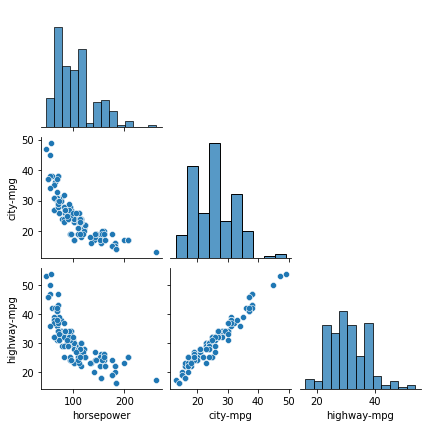

In [14]:
num_features = ['horsepower', 'city-mpg', 'highway-mpg']
sns.pairplot(df[num_features], height = 2.0, corner=True)
plt.show()

In [15]:
for variable in df:
    if str(df[variable].dtype).lower() in ['int32', 'int64', 'uint8']:
        continue
    print(variable, df[variable].dtype)

symboling object
normalized-losses float64
make object
fuel-type object
aspiration object
num-of-doors float64
body-style object
drive-wheels object
engine-location object
wheel-base float64
length float64
width float64
height float64
engine-type object
fuel-system object
bore float64
compression-ratio float64
horsepower float64
peak-rpm float64
price float64


### Data Preparation instead of Pipeline

In [16]:
# One-hot encoding is essentially the representation of categorical variables as binary vectors
# Pandas get dummies allows you to easily one-hot encode your categorical data
# Todas as variáveis objetct type devem ser convertidas para numéricas

for var, prefix in [('make', 'madeby'), ('fuel-type', 'fuel'), ('drive-wheels', 'drive'), ('body-style', 'body'), ('fuel-system', 'fuel_sys'), ('engine-type', 'engine'), ('aspiration', 'aspiration'), ('engine-location', 'engine-location'), ('symboling', 'symboling')]:
    df = pd.get_dummies(df, prefix=prefix, columns=[var])

In [17]:
# Partir o dataset, em modelo de treino (80%) e modelo de teste (20%)

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=0) 
x_train = train_set.drop('price', axis=1) # variáveis todas menos a variável que queremos prever (preço)
y_train = train_set['price'] # variável que queremos prever - y
x_test = test_set.drop('price', axis=1)
y_test = test_set['price']

In [18]:
# Impute da mediana para “Bore” = N/A

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
for var in ['normalized-losses', 'bore']:
    x_train.loc[:,var] = imputer.fit_transform(x_train[[var]])
    x_test.loc[:,var] = imputer.transform(x_test[[var]])

In [19]:
# Regression metrics
# mean_squared_error (RMSE) - quanto menor, melhor (objeto de pontuação para escolher o melhor modelo)


from sklearn.metrics import mean_squared_error, r2_score as get_r2_score

def get_rmse(test, pred):
    return np.sqrt(mean_squared_error(test, pred))

def plot_real_predicted_and_diff(prediction, label):
    result = test_set.copy()
    result.insert(0, 'index', range(len(test_set)), True)
    result.insert(1, 'predicted', prediction, True)
    fig, ax1 = plt.subplots(figsize=(10,5))
    fig.suptitle(label, fontsize=20)
    _ = sns.lineplot(data=result, x='index', y='price', color='grey', ax=ax1, label='real')
    _ = sns.lineplot(data=result, x='index', y='predicted', color='red', ax=ax1, label='predicted')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(10,5))
    fig.suptitle(label, fontsize=20)
    result['diff'] = 100 * (result['predicted'] - result['price']) / result['predicted']
    _ = sns.lineplot(data=result, x='index', y='diff', color='red', label='% Diff')

### Algorithms and Evaluation

In [20]:
# LinearRegression | RandomForestRegressor | LGBMRegressor

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_prediction = lr.predict(x_test)

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train, y_train)
rfr_prediction = rfr.predict(x_test)

from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(random_state=0)
lgbm.fit(x_train, y_train)
lgbm_prediction = lgbm.predict(x_test)

print(f'\nLinearRegression\n\tRMSE: {get_rmse(y_test, lr_prediction)}\n\tR2: {get_r2_score(y_test, lr_prediction)}')
print(f'\nRandomForestRegressor\n\tRMSE: {get_rmse(y_test, rfr_prediction)}\n\tR2: {get_r2_score(y_test, rfr_prediction)}')
print(f'\nLGBMRegressor\n\tRMSE: {get_rmse(y_test, lgbm_prediction)}\n\tR2: {get_r2_score(y_test, lgbm_prediction)}')


LinearRegression
	RMSE: 2199.0352559732546
	R2: 0.9270596508654594

RandomForestRegressor
	RMSE: 2114.346963366368
	R2: 0.9325695642805387

LGBMRegressor
	RMSE: 2438.8977974334784
	R2: 0.9102797125602549


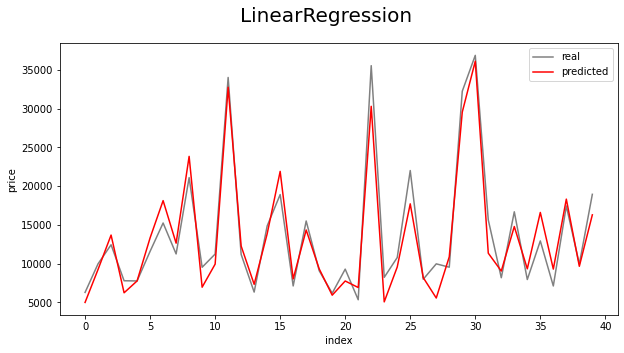

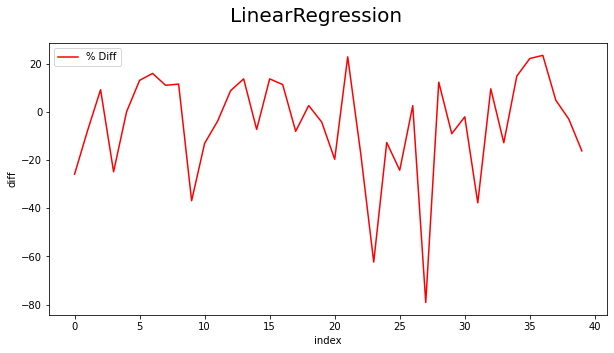

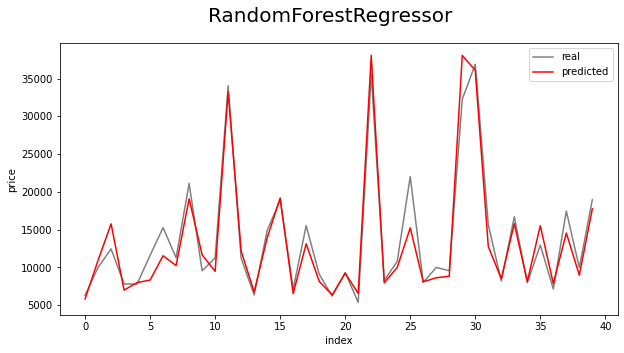

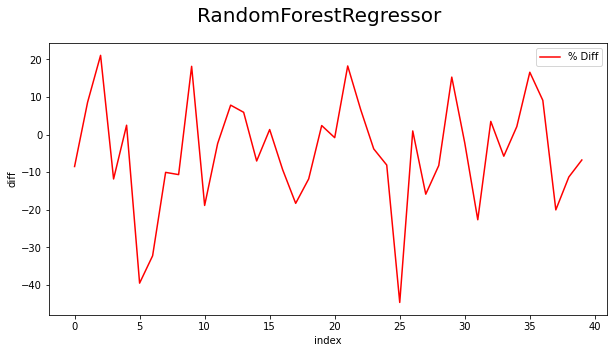

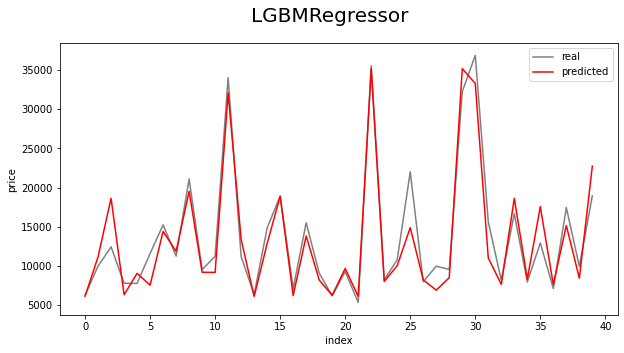

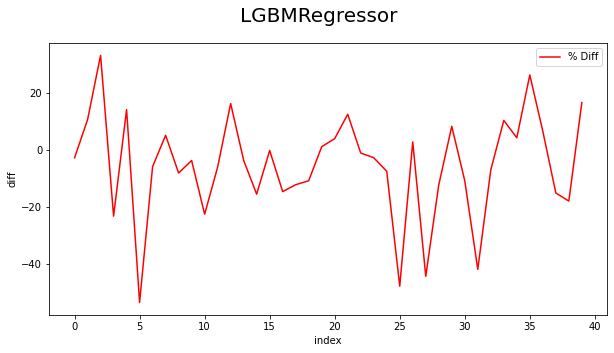

In [21]:
plot_real_predicted_and_diff(lr_prediction, 'LinearRegression ')
plot_real_predicted_and_diff(rfr_prediction, 'RandomForestRegressor')
plot_real_predicted_and_diff(lgbm_prediction, 'LGBMRegressor')

### HyperParameter Tuning

In [22]:
# GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

pipe = Pipeline([('regressor', DummyRegressor())])
search_space = [
    {
        'regressor': [LinearRegression()]
    }, {
        'regressor': [RandomForestRegressor(random_state=0)],
        'regressor__n_estimators': [80, 100, 120, 140, 160, 180, 200],
        'regressor__max_depth': [None, 5, 10, 15, 20]
    }, {
        'regressor': [LGBMRegressor(random_state=0)],
        'regressor__num_leaves': [80, 100, 120, 140, 160, 180, 200],
        'regressor__max_depth': [10, 50, 100, 500, 1000]
    }
]

gs = GridSearchCV(pipe, search_space, cv=10, scoring='neg_mean_squared_error')
model = gs.fit(x_train, y_train)
y_pred = gs.predict(x_test)
best_model = model.best_params_['regressor']
print(f'Best Model: {best_model}\tRMSE: {get_rmse(y_test, y_pred)}\n\tR2: {get_r2_score(y_test, y_pred)}')

Best Model: RandomForestRegressor(max_depth=10, n_estimators=140, random_state=0)
	RMSE: 2148.060785594198
	R2: 0.9304020276857543


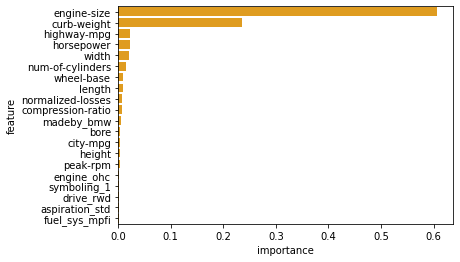

In [23]:
importances = pd.DataFrame({'feature': x_train.columns, 'importance': gs.best_estimator_['regressor'].feature_importances_})
top_importances = importances.sort_values('importance', ascending=False).head(20)
_ = sns.barplot(data=top_importances, x='importance', y='feature', color='orange')

### Get the best model for the app


In [29]:
# vamos ser apenas consideradas as top 5 features na app (por acaso são todas variáveis numéricas e não categóricas)

app_df = df[list(top_importances.head(5)['feature']) + ['price']]

app_train_set, app_test_set = train_test_split(app_df, test_size=0.2, random_state=0)
app_x_train = app_train_set.drop('price', axis=1)
app_y_train = app_train_set['price']
app_x_test = app_test_set.drop('price', axis=1)
app_y_test = app_test_set['price']

app_model = RandomForestRegressor(random_state=0, max_depth=10, n_estimators=140)
app_model.fit(app_x_train, app_y_train)
app_rfr_prediction = app_model.predict(app_x_test)

app_y_pred = app_model.predict(app_x_test)
print(f'\tRMSE: {get_rmse(app_y_test, app_y_pred)}\n\tR2: {get_r2_score(app_y_test, app_y_pred)}')

	RMSE: 2009.744521841639
	R2: 0.9390764557872312


In [30]:
import pickle

with open('mega_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
app_df.describe()

In [ ]:
 encodedZip = base64.b64encode(f.read())
    print(encodedZip.decode())